<a href="https://colab.research.google.com/github/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/MI_FGSM_Attack_for_ImageNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### <b>Load Required Libraries</b>

In [ ]:
!git clone https://github.com/ndb796/PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST
%cd PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST/datasets

Cloning into 'PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST'...
remote: Enumerating objects: 6145, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 6145 (delta 68), reused 0 (delta 0), pack-reused 6014
Receiving objects: 100% (6145/6145), 650.43 MiB | 46.64 MiB/s, done.
Resolving deltas: 100% (69/69), done.
Checking out files: 100% (5017/5017), done.
/content/PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST/datasets


In [ ]:
# load required PyTorch libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [ ]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

#### <b>Load ImageNet Classes</b>

In [ ]:
from urllib.request import urlretrieve
import json

# load 1,000 labels from the ImageNet config file
with open('./imagenet.json') as f:
    imagenet_labels = json.load(f)

print(imagenet_labels[18])

magpie


#### <b>Image Visualization</b>

In [ ]:
imsize = 224

preprocess = transforms.Compose([
    transforms.Resize((imsize, imsize)), # resize the image size
    transforms.ToTensor(), # [0, 255] → [0, 1] torch.Tensor
])

In [ ]:
# load an image visualization library
import matplotlib.pyplot as plt
import PIL

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

In [ ]:
# load an image and get a torch.Tensor object
def image_loader(path):
    image = PIL.Image.open(path)
    image = preprocess(image).unsqueeze(0) # [1, 3, H, W]
    return image.to(device, torch.float)

In [ ]:
image = image_loader('./ILSVRC2012_img_val_subset/18/ILSVRC2012_val_00000476.JPEG')

In [ ]:
# show torch.Tensor image
def imshow(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0) # [3, H, W]
    image = transforms.ToPILImage()(image)
    # show an image whose values are between [0, 1]
    plt.imshow(image)
    plt.show()

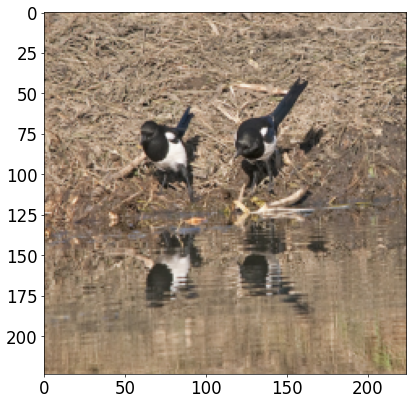

In [ ]:
imshow(image)

#### <b>Load Pre-trained Classification Model</b>

In [ ]:
# input data normalization class
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [ ]:
model = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # add an input normalization layer
    torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
).to(device).eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
outputs = model(image)
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
print("< Highest Confidence Classes >")
for i in outputs[0].topk(5)[1]:
    print(f"Index: {i.item()} / Class name: {imagenet_labels[i]} / Probability: {round(percentages[i].item(), 4)}%")

< Highest Confidence Classes >
Index: 18 / Class name: magpie / Probability: 76.3741%
Index: 80 / Class name: black grouse / Probability: 17.3179%
Index: 137 / Class name: American coot, marsh hen, mud hen, water hen, Fulica americana / Probability: 1.0765%
Index: 93 / Class name: hornbill / Probability: 0.6028%
Index: 128 / Class name: black stork, Ciconia nigra / Probability: 0.5908%


In [ ]:
black_box_model = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # add an input normalization layer
    torch.hub.load('pytorch/vision:v0.6.0', 'vgg19', pretrained=True)
).to(device).eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


#### <b>Load Validation Dataset</b>

In [ ]:
import os
from torchvision import datasets

data_dir = './ILSVRC2012_img_val_subset'

val_dataset = datasets.ImageFolder(os.path.join(data_dir), preprocess)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=2)
print('Validation dataset size:', len(val_dataset))

class_names = val_dataset.classes
print('The number of classes:', len(class_names))

Validation dataset size: 5000
The number of classes: 1000


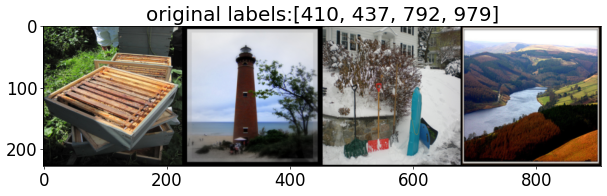

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: apiary, bee house (410)
Image #2: beacon, lighthouse, beacon light, pharos (437)
Image #3: shovel (792)
Image #4: valley, vale (979)


In [ ]:
import torchvision
import numpy as np


def imshow_batch(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of validation image
iterator = iter(val_dataloader)

# visualize a batch of validation image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow_batch(out, title='original labels:' + str([int(class_names[x]) for x in classes[:4]]))

print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
for i, x in enumerate(classes[:4]):
    imagenet_index = int(class_names[x])
    label = imagenet_labels[imagenet_index]
    print(f'Image #{i + 1}: {label} ({imagenet_index})')

#### <b>Validation Phase</b>

* White-box model

[Prediction Result Examples]


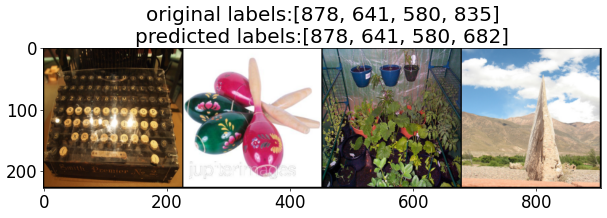

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: typewriter keyboard (878)
Image #2: maraca (641)
Image #3: greenhouse, nursery, glasshouse (580)
Image #4: sundial (835)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: typewriter keyboard (878)
Image #2: maraca (641)
Image #3: greenhouse, nursery, glasshouse (580)
Image #4: obelisk (682)


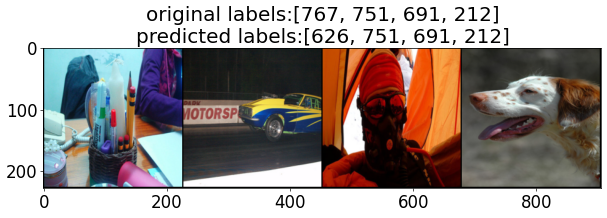

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: rubber eraser, rubber, pencil eraser (767)
Image #6: racer, race car, racing car (751)
Image #7: oxygen mask (691)
Image #8: English setter (212)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: lighter, light, igniter, ignitor (626)
Image #6: racer, race car, racing car (751)
Image #7: oxygen mask (691)
Image #8: English setter (212)
[Validation] Loss: 0.0619 Accuracy: 76.0600% Time elapsed: 33.4278s (total 5000 images)


In [ ]:
import time

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, basic_labels) in enumerate(val_dataloader):
        inputs = inputs.to(device)
        labels = torch.zeros_like(basic_labels).to(device)
        for j in range(labels.shape[0]):
            labels[j] = int(class_names[basic_labels[j]])
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[:4]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')

    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = running_corrects / len(val_dataset) * 100.
    print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

* Black-box model

[Prediction Result Examples]


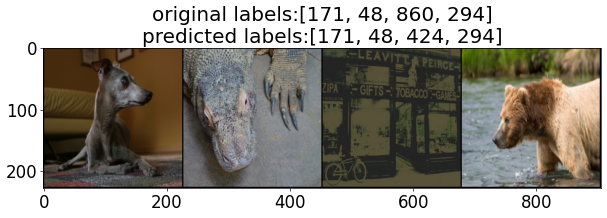

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: Italian greyhound (171)
Image #2: Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis (48)
Image #3: tobacco shop, tobacconist shop, tobacconist (860)
Image #4: brown bear, bruin, Ursus arctos (294)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: Italian greyhound (171)
Image #2: Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis (48)
Image #3: barbershop (424)
Image #4: brown bear, bruin, Ursus arctos (294)


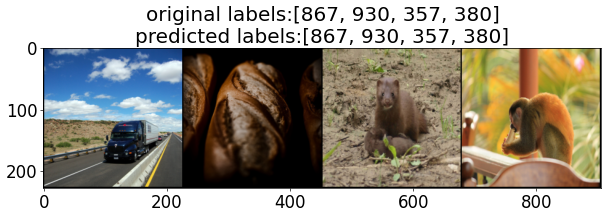

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi (867)
Image #6: French loaf (930)
Image #7: mink (357)
Image #8: titi, titi monkey (380)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi (867)
Image #6: French loaf (930)
Image #7: mink (357)
Image #8: titi, titi monkey (380)
[Validation] Loss: 0.0727 Accuracy: 71.1600% Time elapsed: 37.3647s (total 5000 images)


In [ ]:
import time

criterion = nn.CrossEntropyLoss()
black_box_model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, basic_labels) in enumerate(val_dataloader):
        inputs = inputs.to(device)
        labels = torch.zeros_like(basic_labels).to(device)
        for j in range(labels.shape[0]):
            labels[j] = int(class_names[basic_labels[j]])
        labels = labels.to(device)

        outputs = black_box_model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[:4]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')

    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = running_corrects / len(val_dataset) * 100.
    print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

#### <b>Prepare Adversarial Attack Libraries</b>

In [ ]:
def get_distance(a, b):
    l0 = torch.norm((a - b).view(a.shape[0], -1), p=0, dim=1)
    l2 = torch.norm((a - b).view(a.shape[0], -1), p=2, dim=1)
    mse = (a - b).view(a.shape[0], -1).pow(2).mean(1)
    linf = torch.norm((a - b).view(a.shape[0], -1), p=float('inf'), dim=1)
    return l0, l2, mse, linf

In [ ]:
# FGSM 공격 함수
def fgsm_attack(model, images, labels, eps):
    # 이미지와 레이블 데이터를 GPU로 옮기기
    images = images.to(device)
    labels = labels.to(device)

    # 입력 이미지와 동일한 크기를 갖는 노이즈(perturbation) 생성
    perturbation = torch.zeros_like(images).to(device)
    # 손실(loss) 함수 설정
    attack_loss = nn.CrossEntropyLoss()

    # required_grad 속성의 값을 True로 설정하여 해당 torch.Tensor의 연산을 추적
    perturbation.requires_grad = True

    outputs = model(images + perturbation) # 모델의 판단 결과 확인

    # 손실 함수에 대하여 미분하여 기울기(gradient) 계산
    model.zero_grad()
    cost = attack_loss(outputs, labels).to(device)
    cost.backward()

    # 계산된 기울기(gradient)를 이용하여 손실 함수가 증가하는 방향으로 업데이트
    diff = perturbation.grad.sign()
    # 결과적으로 노이즈(perturbation)의 각 픽셀의 값이 [-eps, eps] 사이의 값이 되도록 자르기
    perturbation = torch.clamp(perturbation + diff, min=-eps, max=eps).detach_() # 연산을 추적하는 것을 중단하기 위해 detach() 호출

    # (최종적으로 만들어진 공격 이미지, 노이즈) 반환
    current = torch.clamp(images + perturbation, min=0, max=1)
    return current, perturbation

In [ ]:
# PGD 공격 함수
def pgd_attack(model, images, labels, targeted, eps, alpha, iters):
    # 이미지와 레이블 데이터를 GPU로 옮기기
    images = images.to(device)
    labels = labels.to(device)

    # 입력 이미지와 동일한 크기를 갖는 노이즈(perturbation) 생성
    # 노이즈 값은 음수가 될 수 있으므로, 평균이 0인 균등한(uniform) 랜덤 값으로 설정
    perturbation = torch.empty_like(images).uniform_(-eps, eps).to(device)
    # 손실(loss) 함수 설정
    attack_loss = nn.CrossEntropyLoss()

    for i in range(iters):
        # required_grad 속성의 값을 True로 설정하여 해당 torch.Tensor의 연산을 추적
        perturbation.requires_grad = True

        # 현재 공격 이미지(원래 이미지에 노이즈를 섞고, 그 결과가 [0, 1] 범위에 속하도록 자르기)
        current = torch.clamp(images + perturbation, min=0, max=1)
        outputs = model(current) # 모델의 판단 결과 확인

        # 손실 함수에 대하여 미분하여 기울기(gradient) 계산
        model.zero_grad()
        cost = attack_loss(outputs, labels).to(device)
        cost.backward()

        if targeted: # 타겟이 있는(targeted) 공격인 경우
            # 계산된 기울기(gradient)를 이용하여 손실 함수가 감소하는 방향으로 업데이트
            diff = -alpha * perturbation.grad.sign()
        else:
            # 계산된 기울기(gradient)를 이용하여 손실 함수가 증가하는 방향으로 업데이트
            diff = alpha * perturbation.grad.sign()
        # 결과적으로 노이즈(perturbation)의 각 픽셀의 값이 [-eps, eps] 사이의 값이 되도록 자르기
        perturbation = torch.clamp(perturbation + diff, min=-eps, max=eps).detach_() # 연산을 추적하는 것을 중단하기 위해 detach() 호출

    # (최종적으로 만들어진 공격 이미지, 노이즈) 반환
    current = torch.clamp(images + perturbation, min=0, max=1)
    return current, perturbation

In [ ]:
# MI-FGSM 공격 함수
def mi_fgsm_attack(model, images, labels, targeted, eps, alpha, iters, decay):
    # 이미지와 레이블 데이터를 GPU로 옮기기
    images = images.to(device)
    labels = labels.to(device)

    # 입력 이미지와 동일한 크기를 갖는 노이즈(perturbation) 생성
    # 노이즈 값은 음수가 될 수 있으므로, 평균이 0인 균등한(uniform) 랜덤 값으로 설정
    perturbation = torch.empty_like(images).uniform_(-eps, eps).to(device)
    # 손실(loss) 함수 설정
    attack_loss = nn.CrossEntropyLoss()

    for i in range(iters):
        # required_grad 속성의 값을 True로 설정하여 해당 torch.Tensor의 연산을 추적
        perturbation.requires_grad = True

        # 현재 공격 이미지(원래 이미지에 노이즈를 섞고, 그 결과가 [0, 1] 범위에 속하도록 자르기)
        current = torch.clamp(images + perturbation, min=0, max=1)
        outputs = model(current) # 모델의 판단 결과 확인

        # 손실 함수에 대하여 미분하여 기울기(gradient) 계산
        model.zero_grad()
        cost = attack_loss(outputs, labels).to(device)
        cost.backward()
        
        grad = perturbation.grad
        grad_norm = torch.norm(grad.view(inputs.shape[0], -1), p=1, dim=1)
        grad = grad / grad_norm.view(-1, 1, 1, 1)
        if i != 0:
            grad = momentum * decay + grad
        momentum = grad

        if targeted: # 타겟이 있는(targeted) 공격인 경우
            # 계산된 기울기(gradient)를 이용하여 손실 함수가 감소하는 방향으로 업데이트
            diff = -alpha * grad.sign()
        else:
            # 계산된 기울기(gradient)를 이용하여 손실 함수가 증가하는 방향으로 업데이트
            diff = alpha * grad.sign()
        # 결과적으로 노이즈(perturbation)의 각 픽셀의 값이 [-eps, eps] 사이의 값이 되도록 자르기
        perturbation = torch.clamp(perturbation + diff, min=-eps, max=eps).detach_() # 연산을 추적하는 것을 중단하기 위해 detach() 호출

    # (최종적으로 만들어진 공격 이미지, 노이즈) 반환
    current = torch.clamp(images + perturbation, min=0, max=1)
    return current, perturbation

In [ ]:
import time

eps = 16/255
alpha = 2/255
iters = 20

criterion = nn.CrossEntropyLoss()
model.eval().to(device)
black_box_model.eval().to(device)

Sequential(
  (0): Normalize()
  (1): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

#### <b>FGSM Attack</b>

* White-box attack

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


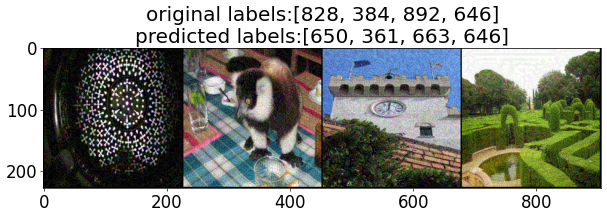

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: strainer (828)
Image #2: indri, indris, Indri indri, Indri brevicaudatus (384)
Image #3: wall clock (892)
Image #4: maze, labyrinth (646)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: microphone, mike (650)
Image #2: skunk, polecat, wood pussy (361)
Image #3: monastery (663)
Image #4: maze, labyrinth (646)


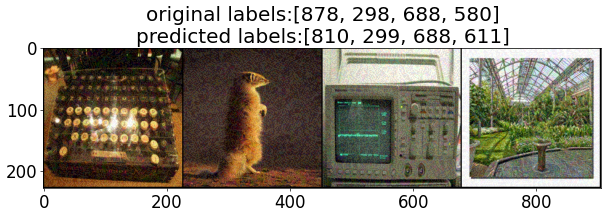

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: typewriter keyboard (878)
Image #6: mongoose (298)
Image #7: oscilloscope, scope, cathode-ray oscilloscope, CRO (688)
Image #8: greenhouse, nursery, glasshouse (580)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: space bar (810)
Image #6: meerkat, mierkat (299)
Image #7: oscilloscope, scope, cathode-ray oscilloscope, CRO (688)
Image #8: jigsaw puzzle (611)
[Step #0] Loss: 0.3830 Accuracy: 12.5000% Time elapsed: 1.0369s (total 16 images)
[Step #10] Loss: 0.3871 Accuracy: 7.9545% Time elapsed: 3.2023s (total 176 images)
[Step #20] Loss: 0.3865 Accuracy: 7.4405% Time elapsed: 5.3713s (total 336 images)
[Step #30] Loss: 0.4026 Accuracy: 6.0484% Time elapsed: 7.5425s (total 496 images)
[Step #40] Loss: 0.3997 Accuracy: 6.2500% Time elapsed: 9.7268s (total 656 images)
[Step #50] Loss: 0.3951 Accuracy: 7.5980% Time elapsed: 11.9145s (total 816 images)
[Step #60] Loss: 0.3975 Accuracy: 7.8893% Time elapsed: 14.1056s (total 976 images)
[

In [ ]:
running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

start_time = time.time()

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted, perturbation = fgsm_attack(model, inputs, labels, eps)  # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

* Black-box attack

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


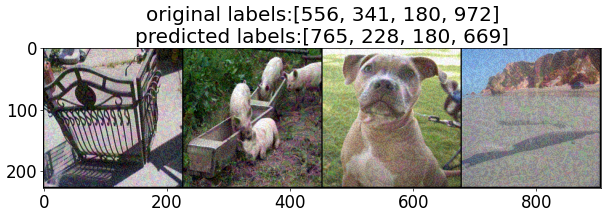

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: fire screen, fireguard (556)
Image #2: hog, pig, grunter, squealer, Sus scrofa (341)
Image #3: American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier (180)
Image #4: cliff, drop, drop-off (972)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: rocking chair, rocker (765)
Image #2: komondor (228)
Image #3: American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier (180)
Image #4: mosquito net (669)


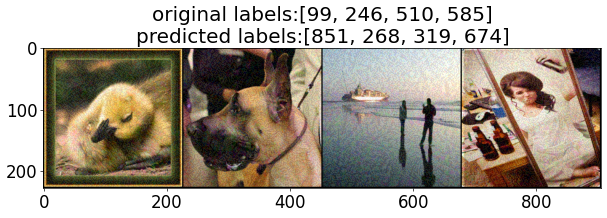

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: goose (99)
Image #6: Great Dane (246)
Image #7: container ship, containership, container vessel (510)
Image #8: hair spray (585)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: television, television system (851)
Image #6: Mexican hairless (268)
Image #7: dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk (319)
Image #8: mousetrap (674)
[Step #0] Loss: 0.2806 Accuracy: 25.0000% Time elapsed: 1.0031s (total 16 images)
[Step #10] Loss: 0.2716 Accuracy: 21.5909% Time elapsed: 3.5410s (total 176 images)
[Step #20] Loss: 0.2814 Accuracy: 19.3452% Time elapsed: 6.0985s (total 336 images)
[Step #30] Loss: 0.2765 Accuracy: 19.5564% Time elapsed: 8.6578s (total 496 images)
[Step #40] Loss: 0.2662 Accuracy: 20.7317% Time elapsed: 11.2186s (total 656 images)
[Step #50] Loss: 0.2566 Accuracy: 22.3039% Time elapsed: 13.7808s (total 816 images)
[Step #60] Loss: 0.2551 Accur

In [ ]:
running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

start_time = time.time()

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted, perturbation = fgsm_attack(model, inputs, labels, eps)  # adversarial attack

    outputs = black_box_model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

#### <b>PGD Attack</b>

* White-box attack

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


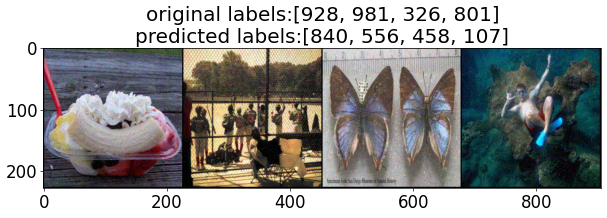

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: ice cream, icecream (928)
Image #2: ballplayer, baseball player (981)
Image #3: lycaenid, lycaenid butterfly (326)
Image #4: snorkel (801)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: swab, swob, mop (840)
Image #2: fire screen, fireguard (556)
Image #3: brass, memorial tablet, plaque (458)
Image #4: jellyfish (107)


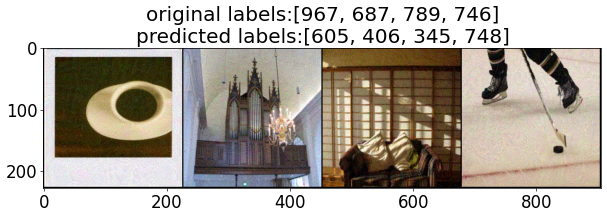

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: espresso (967)
Image #6: organ, pipe organ (687)
Image #7: shoji (789)
Image #8: puck, hockey puck (746)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: iPod (605)
Image #6: altar (406)
Image #7: ox (345)
Image #8: purse (748)
[Step #0] Loss: 6.2568 Accuracy: 0.0000% Time elapsed: 4.0681s (total 16 images)
[Step #10] Loss: 5.6324 Accuracy: 0.0000% Time elapsed: 36.9668s (total 176 images)
[Step #20] Loss: 5.6132 Accuracy: 0.0000% Time elapsed: 69.9180s (total 336 images)
[Step #30] Loss: 5.6610 Accuracy: 0.0000% Time elapsed: 102.9523s (total 496 images)
[Step #40] Loss: 5.4820 Accuracy: 0.0000% Time elapsed: 136.0212s (total 656 images)
[Step #50] Loss: 5.4496 Accuracy: 0.0000% Time elapsed: 169.0613s (total 816 images)
[Step #60] Loss: 5.4254 Accuracy: 0.0000% Time elapsed: 202.0376s (total 976 images)
[Step #70] Loss: 5.4082 Accuracy: 0.0000% Time elapsed: 234.9453s (total 1136 images)
[Step #80] Loss: 5.4240 Accuracy: 0.0000%

In [ ]:
running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

start_time = time.time()

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted, perturbation = pgd_attack(model, inputs, labels, False, eps, alpha, iters)  # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

* Black-box attack

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


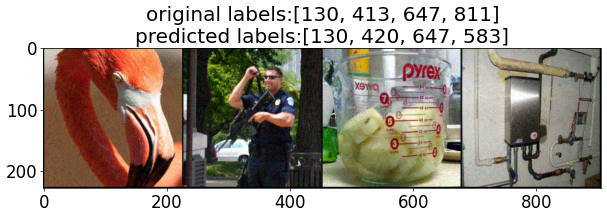

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: flamingo (130)
Image #2: assault rifle, assault gun (413)
Image #3: measuring cup (647)
Image #4: space heater (811)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: flamingo (130)
Image #2: banjo (420)
Image #3: measuring cup (647)
Image #4: guillotine (583)


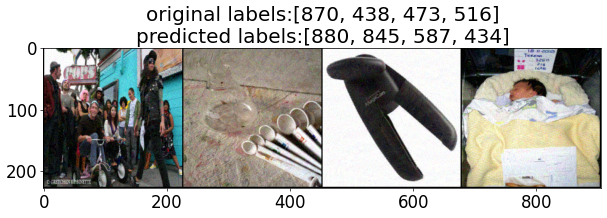

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: tricycle, trike, velocipede (870)
Image #6: beaker (438)
Image #7: can opener, tin opener (473)
Image #8: cradle (516)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: unicycle, monocycle (880)
Image #6: syringe (845)
Image #7: hammer (587)
Image #8: bath towel (434)
[Step #0] Loss: 0.2809 Accuracy: 18.7500% Time elapsed: 4.0710s (total 16 images)
[Step #10] Loss: 0.2350 Accuracy: 31.2500% Time elapsed: 37.5416s (total 176 images)
[Step #20] Loss: 0.2301 Accuracy: 27.9762% Time elapsed: 71.0295s (total 336 images)
[Step #30] Loss: 0.2313 Accuracy: 28.8306% Time elapsed: 104.5110s (total 496 images)
[Step #40] Loss: 0.2349 Accuracy: 27.5915% Time elapsed: 137.9891s (total 656 images)
[Step #50] Loss: 0.2324 Accuracy: 28.0637% Time elapsed: 171.4119s (total 816 images)
[Step #60] Loss: 0.2351 Accuracy: 27.5615% Time elapsed: 204.7830s (total 976 images)
[Step #70] Loss: 0.2345 Accuracy: 27.9049% Time elapsed: 238.1801s (total 1136 i

In [ ]:
running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

start_time = time.time()

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted, perturbation = pgd_attack(model, inputs, labels, False, eps, alpha, iters)  # adversarial attack

    outputs = black_box_model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

#### <b>MI-FGSM Attack</b>

* White-box attack

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


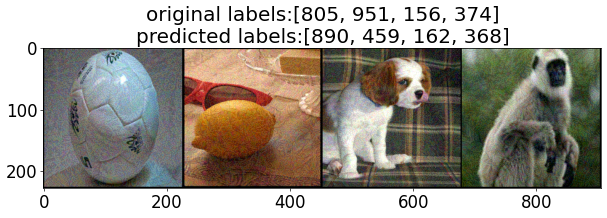

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: soccer ball (805)
Image #2: lemon (951)
Image #3: Blenheim spaniel (156)
Image #4: langur (374)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: volleyball (890)
Image #2: brassiere, bra, bandeau (459)
Image #3: beagle (162)
Image #4: gibbon, Hylobates lar (368)


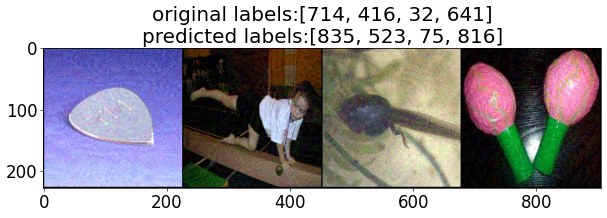

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: pick, plectrum, plectron (714)
Image #6: balance beam, beam (416)
Image #7: tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui (32)
Image #8: maraca (641)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: sundial (835)
Image #6: crutch (523)
Image #7: black widow, Latrodectus mactans (75)
Image #8: spindle (816)
[Step #0] Loss: 7.4093 Accuracy: 0.0000% Time elapsed: 4.0111s (total 16 images)
[Step #10] Loss: 7.2006 Accuracy: 0.0000% Time elapsed: 37.0905s (total 176 images)
[Step #20] Loss: 7.2240 Accuracy: 0.0000% Time elapsed: 70.1567s (total 336 images)
[Step #30] Loss: 7.1704 Accuracy: 0.0000% Time elapsed: 103.2393s (total 496 images)
[Step #40] Loss: 7.1879 Accuracy: 0.0000% Time elapsed: 136.3187s (total 656 images)
[Step #50] Loss: 7.1510 Accuracy: 0.0000% Time elapsed: 169.3935s (total 816 images)
[Step #60] Loss: 7.1391 Accuracy: 0.0000% Time elapsed: 202.4472s (total 976 images)
[Step #70] Loss: 7.1148 Accur

In [ ]:
running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

start_time = time.time()

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted, perturbation = mi_fgsm_attack(model, inputs, labels, False, eps, alpha, iters, decay=1.0)  # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

* Black-box attack

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


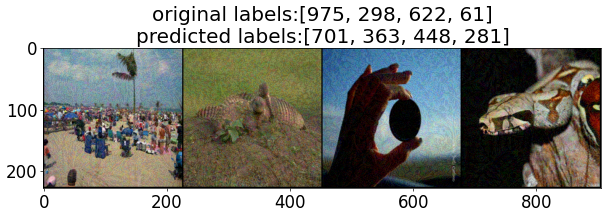

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: lakeside, lakeshore (975)
Image #2: mongoose (298)
Image #3: lens cap, lens cover (622)
Image #4: boa constrictor, Constrictor constrictor (61)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: parachute, chute (701)
Image #2: armadillo (363)
Image #3: birdhouse (448)
Image #4: tabby, tabby cat (281)


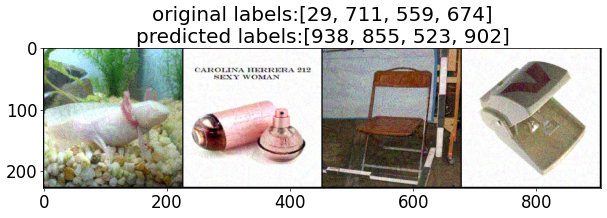

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: axolotl, mud puppy, Ambystoma mexicanum (29)
Image #6: perfume, essence (711)
Image #7: folding chair (559)
Image #8: mousetrap (674)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: cauliflower (938)
Image #6: thimble (855)
Image #7: crutch (523)
Image #8: whistle (902)
[Step #0] Loss: 0.2981 Accuracy: 12.5000% Time elapsed: 4.0131s (total 16 images)
[Step #10] Loss: 0.2986 Accuracy: 14.7727% Time elapsed: 37.4175s (total 176 images)
[Step #20] Loss: 0.2974 Accuracy: 12.7976% Time elapsed: 70.9305s (total 336 images)
[Step #30] Loss: 0.3031 Accuracy: 13.3065% Time elapsed: 104.3996s (total 496 images)
[Step #40] Loss: 0.3098 Accuracy: 14.0244% Time elapsed: 137.8860s (total 656 images)
[Step #50] Loss: 0.3073 Accuracy: 14.4608% Time elapsed: 171.3468s (total 816 images)
[Step #60] Loss: 0.3098 Accuracy: 13.8320% Time elapsed: 204.7644s (total 976 images)
[Step #70] Loss: 0.3098 Accuracy: 13.9085% Time elapsed: 238.2439s (total 11

In [ ]:
running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

start_time = time.time()

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted, perturbation = mi_fgsm_attack(model, inputs, labels, False, eps, alpha, iters, decay=1.0)  # adversarial attack

    outputs = black_box_model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))